In [ ]:
Nicholas Chludzinski

In [ ]:
Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
Preprocess, incorporate feature engineering, introduce hyperparameter tuning, and predict

In [2]:
# Nicholas Chludzinski

def predict_one_week_future(stock_data, company_name, actual_close_8_9):
    # Preprocess the data
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data.set_index('Date', inplace=True)

    # Fill missing values with the mean of each column
    stock_data.fillna(stock_data.mean(), inplace=True)

    # Feature Engineering: Result column
    stock_data['Result'] = np.where(stock_data['Close'].shift(-1) > stock_data['Close'], 1, 0)

    # Feature Engineering: Simple moving average to smooth trend
    stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()

    # Drop any rows with NaN value after feature engineering
    stock_data.dropna(inplace=True)  

    # Select features and target
    features = stock_data[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20']]
    
    # Result will be the target for classification
    target = stock_data['Result']  

    # Split the data into training and testing sets
    X_training, X_testing, y_training, y_testing = train_test_split(features, target, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_training_scaled = scaler.fit_transform(X_training)
    X_testing_scaled = scaler.transform(X_testing)

    # Grid search for hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_training_scaled, y_training)
    best_gb_model = grid_search.best_estimator_

    # Intermediate result after parameter tuning...
    print("Best parameters: ")
    print(grid_search.best_params_)

    # Prepare most recent data point to be fed into model for predicting and transform into 2D array using reshape
    last_data_point = X_testing_scaled[-1].reshape(1, -1)  

    # Predict with the best model and get prediction value
    one_week_prediction = best_gb_model.predict(last_data_point)[0]  

    # Print prediction and actual prices
    print(f"{company_name} - Prediction: The closing price will {'increase' if one_week_prediction == 1 else 'decrease or stay the same'} one week from now.")
    print(f"{company_name} - Actual closing price on 8/2: ${stock_data['Close'].iloc[-1]:.2f}")
    print(f"{company_name} - Actual closing price on 8/9: ${actual_close_8_9:.2f}")

    # Determine if the prediction was correct
    actual_movement = 1 if actual_close_8_9 > stock_data['Close'].iloc[-1] else 0
    predicted_movement = one_week_prediction

    if actual_movement == predicted_movement:
        is_correct = True
        if predicted_movement == 1:
            result = 'TP' if actual_movement == 1 else 'TN'
        else:
            result = 'TN' if actual_movement == 0 else 'FP'
    else:
        is_correct = False
        if predicted_movement == 1:
            result = 'FP'
        else:
            result = 'FN'

    print(f"{company_name} - Was the prediction correct? {'Yes' if is_correct else 'No'} ({result})")
    return is_correct, result


In [ ]:
Provide acutal closing prices to compare against as well as import datasets

In [5]:
# Nicholas Chludzinski

# Actual closing prices on 8/9
actual_closing_prices_8_9 = {
    'Citigroup': 57.84,
    'HUTCHMED': 19.87,
    'Microsoft': 406.02,
    'Tesla': 200.00,
    'Morgan Stanley': 94.72,
    'META': 517.77,
    'Apple': 216.24,
    'NVIDIA': 104.75,
    'Rocket Lab': 5.37,
    'H&R Block': 57.18,
    'Bank of America': 38.28,
    'Sanofi': 52.37
}

# File paths for the stock data
data_paths = {
    'Citigroup': '/Users/nicho/Downloads/C.csv',
    'HUTCHMED': '/Users/nicho/Downloads/HCM.csv',
    'Microsoft': '/Users/nicho/Downloads/MSFT.csv',
    'Tesla': '/Users/nicho/Downloads/TSLA.csv',
    'Morgan Stanley': '/Users/nicho/Downloads/MS.csv',
    'META': '/Users/nicho/Downloads/META.csv',
    'Apple': '/Users/nicho/Downloads/AAPL.csv',
    'NVIDIA': '/Users/nicho/Downloads/NVDA.csv',
    'Rocket Lab': '/Users/nicho/Downloads/RKLB.csv',
    'H&R Block': '/Users/nicho/Downloads/HRB.csv',
    'Bank of America': '/Users/nicho/Downloads/BAC.csv',
    'Sanofi': '/Users/nicho/Downloads/SNY.csv'
}


In [ ]:
Iterate over stock data, compare to actual closing prices, and evaluate accuracy, precision, recall and F1-score

In [7]:
# Nicholas Chludzinski

# Initialize counters
correct_predictions = 0
incorrect_predictions = 0
tp = 0
tn = 0
fp = 0
fn = 0

# Loop through each company
for company, data_path in data_paths.items():
    print(f"\nPredicting for {company}...\n")
    stock_data = pd.read_csv(data_path)
    is_correct, result = predict_one_week_future(stock_data, company, actual_closing_prices_8_9[company])
    
    if is_correct:
        correct_predictions += 1
        if result == 'TP':
            tp += 1
        elif result == 'TN':
            tn += 1
    else:
        incorrect_predictions += 1
        if result == 'FP':
            fp += 1
        elif result == 'FN':
            fn += 1

# Calculate accuracy, precision, recall and F1-score
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print accuracy, precision, recall and F1-score
print(f"\nOverall Accuracy: {accuracy:.2f}")
print(f"Overall Precision: {precision:.2f}")
print(f"Overall Recall: {recall:.2f}")
print(f"Overall F1-Score: {f1_score:.2f}")


Predicting for Citigroup...

Best parameters: 
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Citigroup - Prediction: The closing price will decrease or stay the same one week from now.
Citigroup - Actual closing price on 8/2: $58.76
Citigroup - Actual closing price on 8/9: $57.84
Citigroup - Was the prediction correct? Yes (TN)

Predicting for HUTCHMED...

Best parameters: 
{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}
HUTCHMED - Prediction: The closing price will increase one week from now.
HUTCHMED - Actual closing price on 8/2: $18.13
HUTCHMED - Actual closing price on 8/9: $19.87
HUTCHMED - Was the prediction correct? Yes (TP)

Predicting for Microsoft...

Best parameters: 
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Microsoft - Prediction: The closing price will decrease or stay the same one week from now.
Microsoft - Actual closing price on 8/2: $408.49
Microsoft - Actual closing price on 8/9: $406.02
Microsoft - Was the prediction cor

In [ ]:
Discussion:
The Gradient Boosting Classifier (GBC) achieved an accuracy of 83% (overall correctness), indicating 83% of the models predictions correctly 
predicted stock price movements one week into the future, precision of 71% (proportion of true positive predictions) indicating when the 
model predicted a stock price increase, it was correct 71% of the time, recall of 100% (true positive predictions identified out of all actual positive 
instances) indicating the model identified all instances where the stock price actually increased, and an F1-score of 83% (balance between precision 
and recall) indicating a strong equilibrium between correctly predicted price increases and accurately identifying all actual positive instances 
across 12 randomly selected publicly traded corporations.

In [ ]:
Generate a confusion matrix illustrating TP, FN, FP and TN predicitons, as well as a pie chart displaying distribution between correct 
and incorrect predictions

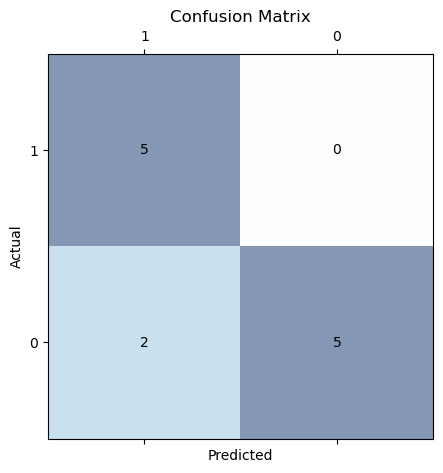

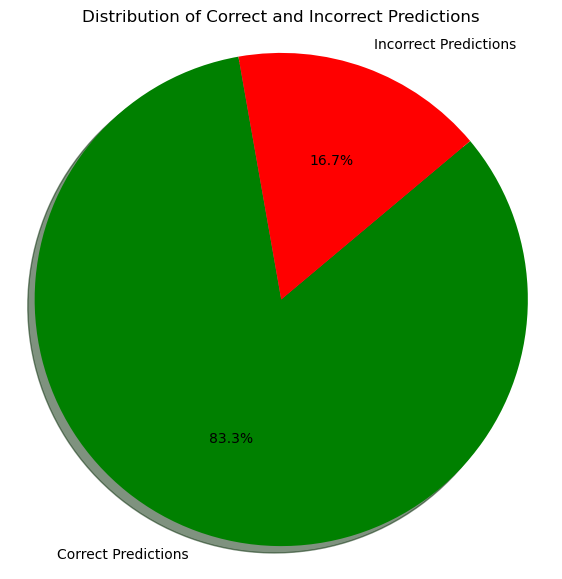

In [8]:
# Nicholas Chludzinski

# Confusion matrix plot
confusion_matrix = np.array([[tp, fn], [fp, tn]])

fig, axis = plt.subplots(figsize=(5, 5))
cmp = axis.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.5)
for (i, j), val in np.ndenumerate(confusion_matrix):
    axis.text(j, i, f'{val}', ha='center', va='center')

# Add axis label and tick
axis.set_xticks([0, 1])
axis.set_yticks([0, 1])
axis.set_xticklabels(['1', '0'])
axis.set_yticklabels(['1', '0'])
axis.set_xlabel('Predicted')
axis.set_ylabel('Actual')

# Add titles and show plot
plt.title('Confusion Matrix')
plt.show()


# Pie chart
labels = ['Correct Predictions', 'Incorrect Predictions']
sizes = [correct_predictions, incorrect_predictions]
colors = ['green', 'red']
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=100)
plt.title('Distribution of Correct and Incorrect Predictions')
plt.axis('equal')
plt.show()


In [ ]:
Discussion:
The confusion matrix visualizes the True Postivie (TP), False Negative (FN), False Positive (FP) and True Negative (TN) instances which have been fed 
into formulas above to calculate accuracy, precision, recall, and F1-score.
A pie chart visualizes the distribution of correct and incorrect predictions. 83.3% of the predictions accurately predict closing stock price trends 
one week into the future and 16.7% of the predictions are incorrect. 